# Data Exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('dark')

%matplotlib inline

In [3]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

In [4]:
train_df['test'] = False
test_df['test'] = True

df = train_df.append(test_df).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 16 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null object
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
latitude           124011 non-null float64
listing_id         124011 non-null int64
longitude          124011 non-null float64
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
test               124011 non-null bool
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 14.3+ MB


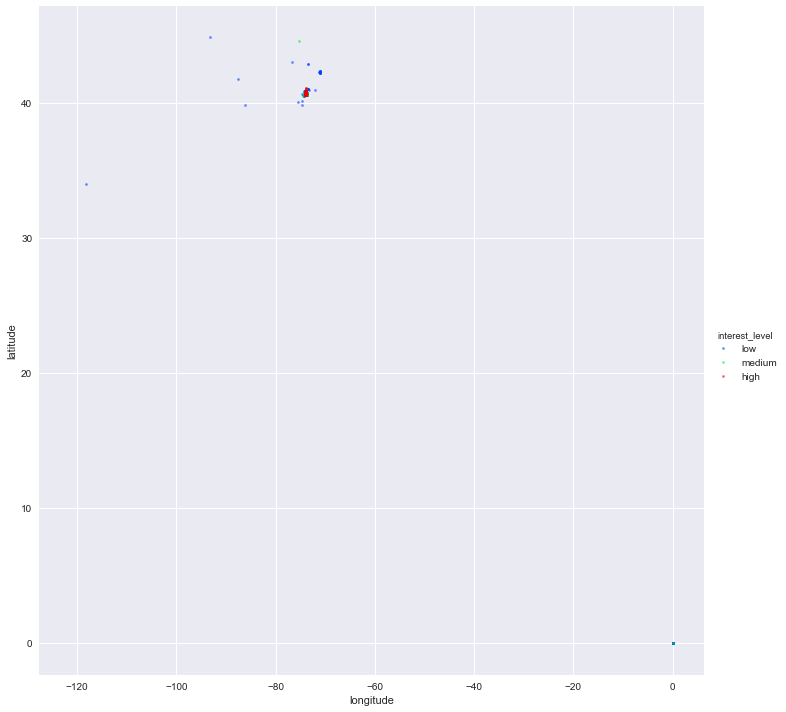

In [5]:
sns.lmplot(x='longitude', y='latitude', data=df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

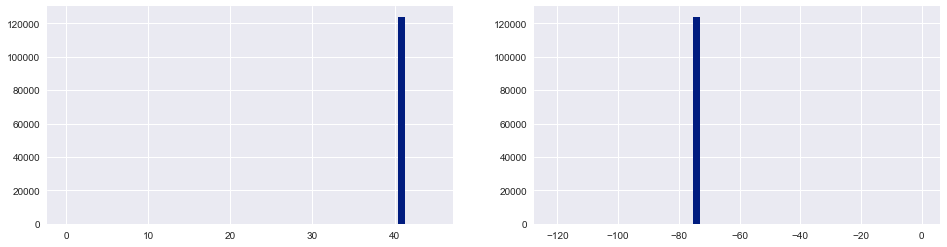

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 50, ax=axes[0])
df.longitude.hist(bins = 50, ax=axes[1])

There are some outliners. We could move them to the center or to the borders or to the nearest cluster.

In [7]:
(lat_min, lat_max), lat_mean = np.percentile(df.latitude, [0.1, 99.9]).tolist(), np.mean(df.latitude)
(lon_min, lon_max), lon_mean = np.percentile(df.longitude, [0.1, 99.9]).tolist(), np.mean(df.longitude)
print "For latitude min/max/mean: %s, %s, %s " % (lat_min, lat_max, lat_mean)
print "For longitude min/max/mean: %s, %s, %s " % (lon_min, lon_max, lon_mean)

df.latitude = np.where(df.latitude < lat_min, lat_min, df.latitude)
df.latitude = np.where(df.latitude > lat_max, lat_max, df.latitude)

df.longitude = np.where(df.longitude < lon_min, lon_min, df.longitude)
df.longitude = np.where(df.longitude > lon_max, lon_max, df.longitude)

For latitude min/max/mean: 40.5758, 40.892, 40.7376406811 
For longitude min/max/mean: -74.036499, -73.7366, -73.9494341187 


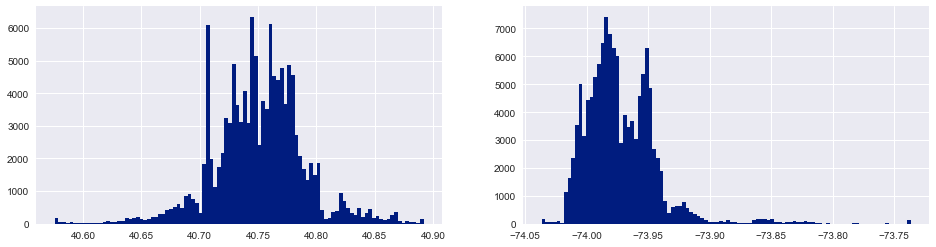

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 100, ax=axes[0])
df.longitude.hist(bins = 100, ax=axes[1])

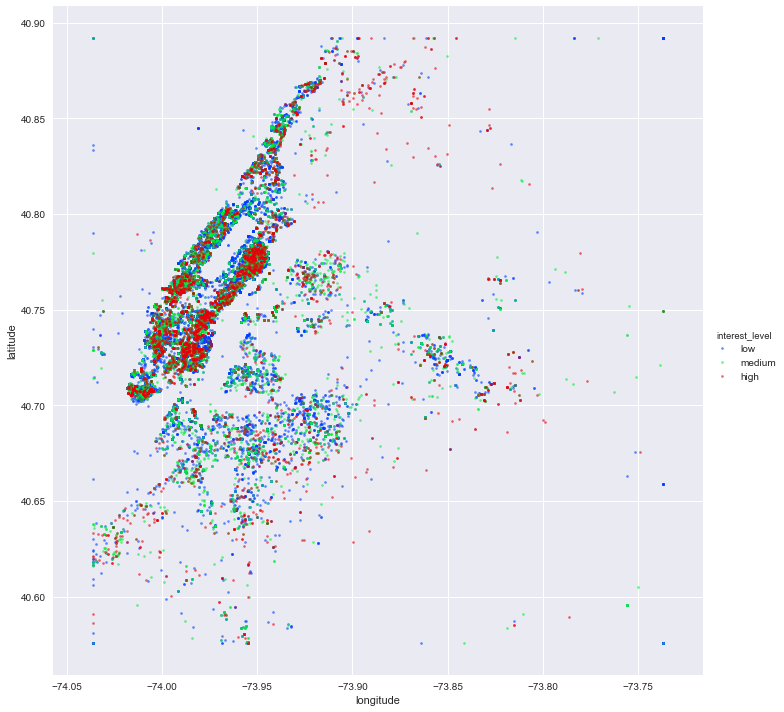

In [9]:
sns.lmplot(x='longitude', y='latitude', data=df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

### zip/neighborhood

In [10]:
import geocoder

g = geocoder.google('Mountain View, CA')
# g = geocoder.google([40.7145, -73.9425], method='reverse') # doesn't work :(
print g.url

https://maps.googleapis.com/maps/api/geocode/json?components=&region=&bounds=&language=&address=Mountain+View%2C+CA


In [11]:
# https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg

rg.search([40.7145, -73.9425]) # default mode = 2, doesn't return zip, clusters are too big

Loading formatted geocoded file...


[{'admin1': 'New York',
  'admin2': 'Queens County',
  'cc': 'US',
  'lat': '40.74482',
  'lon': '-73.94875',
  'name': 'Long Island City'}]

In [12]:
# https://geopy.readthedocs.io/en/1.10.0/
from geopy.geocoders import Nominatim

geolocator = Nominatim()
location = geolocator.reverse("40.7145, -73.9425")

location.raw

{u'address': {u'city': u'NYC',
  u'country': u'United States of America',
  u'country_code': u'us',
  u'county': u'Kings County',
  u'house_number': u'792',
  u'neighbourhood': u'Williamsburg',
  u'postcode': u'11211',
  u'road': u'Metropolitan Avenue',
  u'state': u'New York'},
 u'boundingbox': [u'40.7144593',
  u'40.7146081',
  u'-73.9425107',
  u'-73.9423954'],
 u'display_name': u'792, Metropolitan Avenue, Williamsburg, Kings County, NYC, New York, 11211, United States of America',
 u'lat': u'40.71453375',
 u'licence': u'Data \xa9 OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
 u'lon': u'-73.9424530536828',
 u'osm_id': u'279667988',
 u'osm_type': u'way',
 u'place_id': u'127770087'}

In [13]:
coordinates = df[['listing_id', 'latitude', 'longitude']]

lat_lon, listings = [], []

for i, j in coordinates.iterrows():
    lat_lon.append((j['latitude'], j['longitude']))
    listings.append(int(j['listing_id']))

In [14]:
results = rg.search(lat_lon)

In [15]:
geocoded_addresses = pd.DataFrame(results).set_index([listings])
geocoded_addresses['listing_id'] = geocoded_addresses.index
geocoded_addresses.to_csv('geocoded_addresses.csv', header=True, index=False)

In [16]:
geocoded_addresses = pd.read_csv('geocoded_addresses.csv', header=0, names=['city', 'county', 'country', 'lat', 'lon', 'neighbourhood', 'listing_id'])

#geocoded_addresses.columns = ['city', 'county', 'country', 'lat', 'lon', 'neighbourhood', 'listing_id']
geocoded_addresses.set_index([listings])

df = pd.concat([df, geocoded_addresses[['city','county','neighbourhood']]], axis=1)
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,test,city,county,neighbourhood
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,False,New York,Queens County,Long Island City
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,False,New York,New York County,Manhattan
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,False,New York,NaN,New York City


In [17]:
len(df.neighbourhood.unique())

35

In [18]:
len(df.county.unique())

9

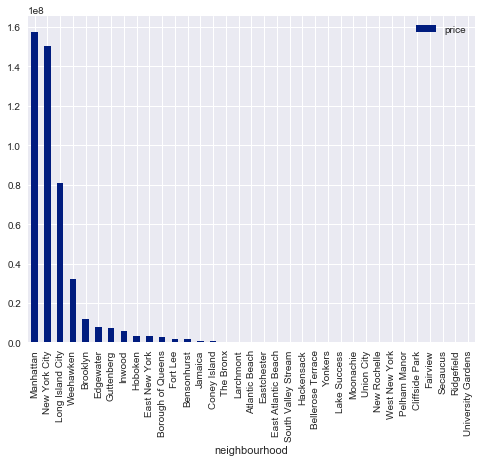

In [19]:
df.groupby('neighbourhood').agg({'price':sum}).sort_values(by='price', ascending=False).plot(kind='bar', figsize=(8,6))

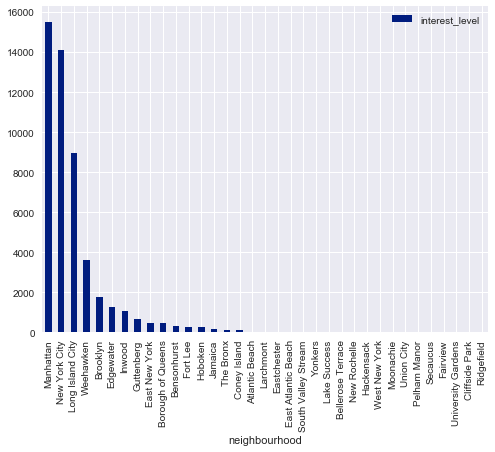

In [20]:
df.groupby('neighbourhood').agg({'interest_level':'count'}).sort_values(by='interest_level', ascending=False).plot(kind='bar', figsize=(8,6))

### clustering

http://scikit-learn.org/stable/modules/clustering.html

In [21]:
df.shape

(124011, 19)

In [22]:
sample = df.sample(n=1000)
sample.shape

(1000, 19)

In [23]:
coords = sample.as_matrix(columns=['longitude','latitude'])

In [24]:
import hdbscan
import time
import sklearn.cluster as cluster
from shapely.geometry import MultiPoint

In [25]:
# taken from http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds).figure.set_size_inches(10,10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    print 'Clustering took %s s' % (end_time - start_time)
    print 'Number of clusters: %s' % len(set(cluster_labels))

Clustering took 0.322558879852 s


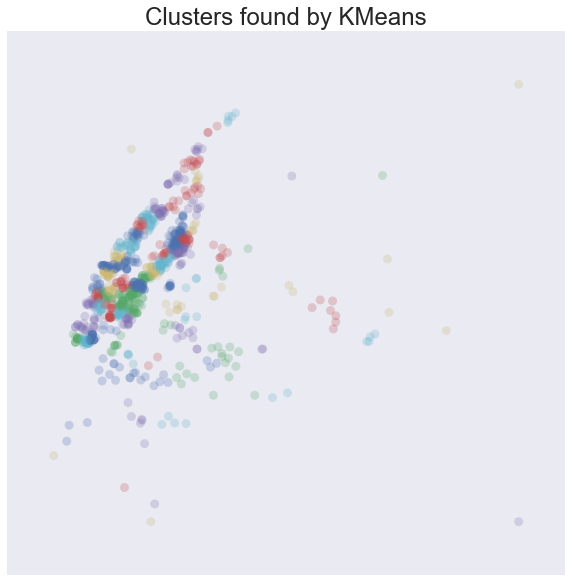

In [26]:
plot_clusters(coords, cluster.KMeans, (), {'n_clusters': 100}) # 6 clusters = on full df 2.13693499565 s

Clustering took 3.26389694214 s


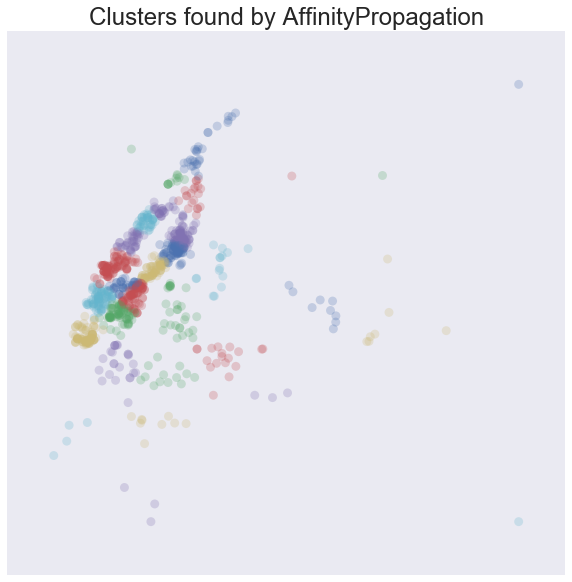

In [27]:
plot_clusters(coords, cluster.AffinityPropagation, (), {}) 
# 'preference':-5.0, 'damping':0.95 - not representative and dead kernel on full df

Clustering took 2.89874696732 s


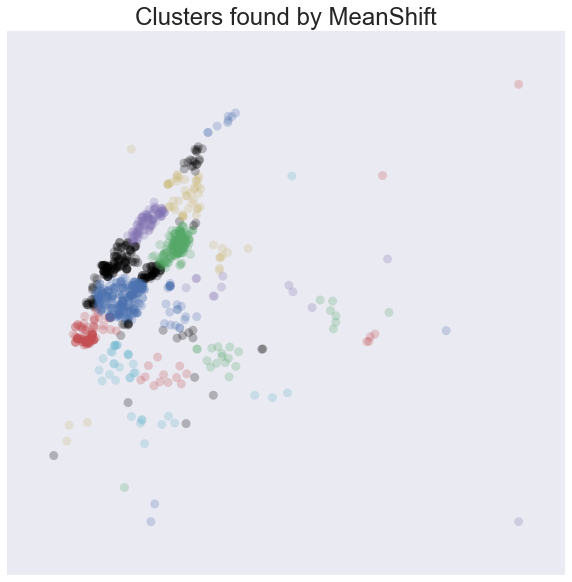

In [28]:
plot_clusters(coords, cluster.MeanShift, (0.0175,), {'cluster_all': False}) 
# 0.175, 'cluster_all':False 1922.56055999 s and not good result on full df

Clustering took 8.35623502731 s


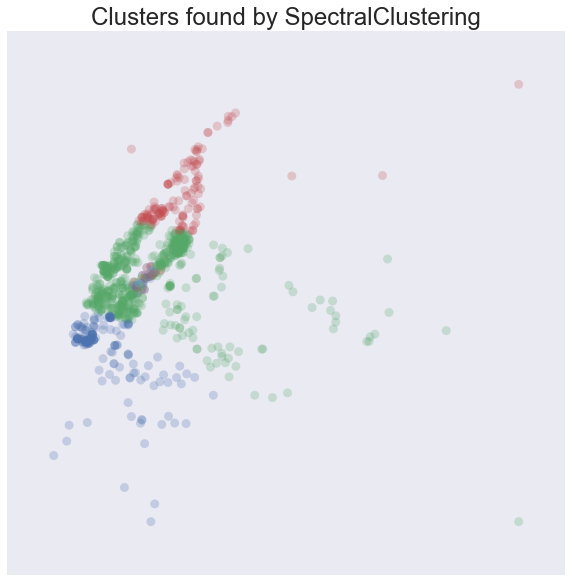

In [29]:
plot_clusters(coords, cluster.SpectralClustering, (), {'n_clusters': 100}) 
# 6 cluster - dead kernel on full df

Clustering took 0.0316250324249 s


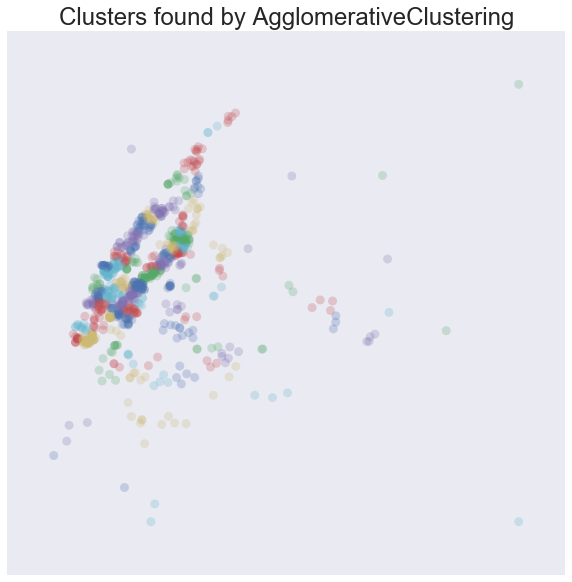

In [30]:
plot_clusters(coords, cluster.AgglomerativeClustering, (), {'n_clusters': 100, 'linkage': "ward"}) 
# 'n_clusters':6, 'linkage':'ward' - dead kernel on full df

Clustering took 0.00973200798035 s


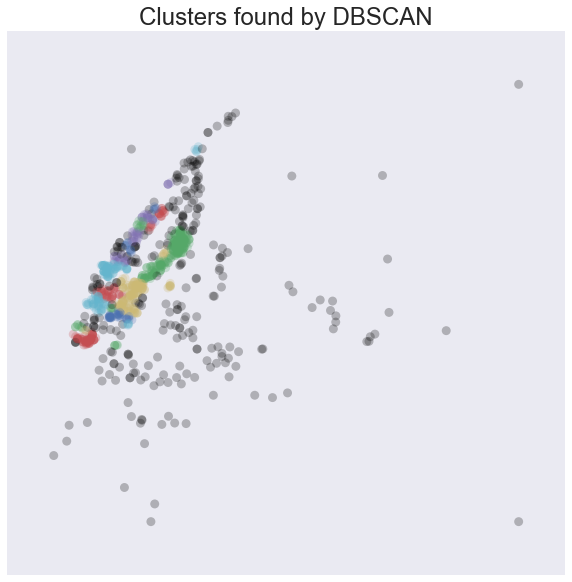

In [31]:
plot_clusters(coords, cluster.DBSCAN, (), {'eps': 0.0025})
# 'eps':0.025 - 1216.05627203 s on a whole df, but not good result

Clustering took 0.00831198692322 s


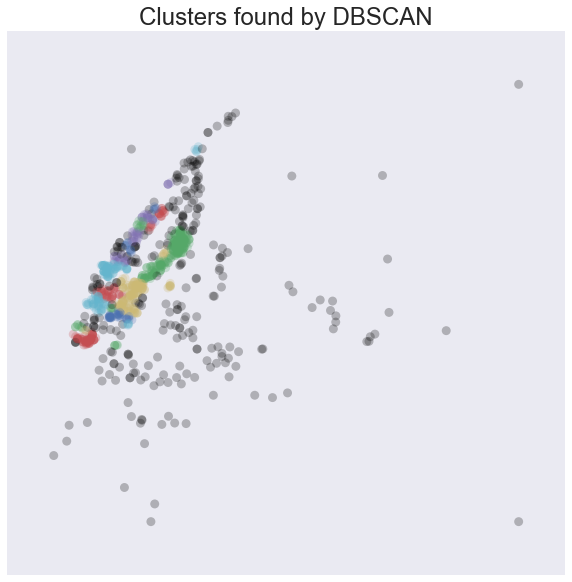

In [32]:
plot_clusters(coords, cluster.DBSCAN, (), {'eps': 0.0025})

Clustering took 0.0283191204071 s


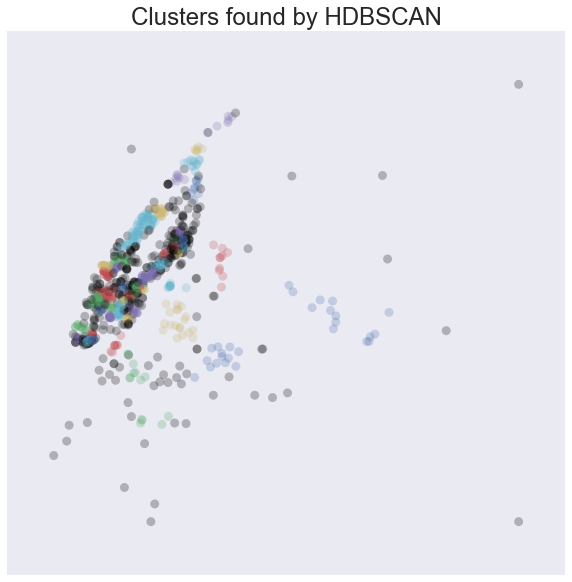

In [33]:
plot_clusters(coords, hdbscan.HDBSCAN, (), {'min_cluster_size': 5})
# 'min_cluster_size':15 - 5.64149212837 s on a whole df, but not good result

In [34]:
coords = df.as_matrix(columns=['longitude', 'latitude'])

In [ ]:
%%time

# followed by http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian # 22 clusters

db = cluster.DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1,num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [ ]:
def get_centeroid(cluster):
    return (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

cluster_centroids = clusters.map(get_centeroid)

In [ ]:
palette = sns.color_palette('deep', np.unique(cluster_labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in cluster_labels]
plt.scatter(coords.T[0], coords.T[1], c=colors, **plot_kwds).figure.set_size_inches(10,10)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [ ]:
import matplotlib

def get_cmap(N):
    '''
    Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.
    '''
    color_norm  = matplotlib.colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = matplotlib.cm.ScalarMappable(norm=color_norm, cmap='nipy_spectral') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [ ]:
cmaps = get_cmap(num_clusters)

for i, cluster in enumerate(clusters):
    lons_select = cluster[:, 1]
    lats_select = cluster[:, 0]
    x, y = (lons_select, lats_select)
    plt.scatter(x,y,marker='o',color=cmaps(i)).figure.set_size_inches(10,10)

### Addresses

In [ ]:
df.display_address.value_counts().head(10)

In [ ]:
df.street_address.value_counts().head(10)

In [ ]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

df['display_address_ascii'] = [remove_accents(line) for line in df.display_address] 
df['street_address_ascii'] = [remove_accents(line) for line in df.street_address] 

pd.DataFrame(df['display_address_ascii'].unique()).to_csv('display_address_ascii.csv')
pd.DataFrame(df['street_address_ascii'].unique()).to_csv('street_address_ascii.csv')

In [ ]:
def clean_addresses(input_str):
    hexadecimals = re.compile('[^a-zA-Z0-9 ]').sub(' ', input_str).lower()
    
    hexadecimals = hexadecimals.replace(' avenue', ' ave').replace(' boulevard', ' blvd')\
        .replace(' street', ' st').replace(' road', ' rd').replace(' place', ' pl')\
        .replace(' terrace', ' tr').replace(' lane', ' ln')\
        .replace(' south', ' s').replace(' north', ' n').replace(' east', ' e').replace(' west', ' w')\
        .replace('south ', 's ').replace('north ', 'n ').replace('east ', 'e ').replace('west ', 'w ')\
        .split(" ")
    
    return " ".join([x.strip() for x in hexadecimals if x != ''])

In [ ]:
df['display_address_clean'] = df.display_address_ascii.apply(clean_addresses)
df.display_address_clean.value_counts().head(10)

In [ ]:
df['street_address_clean'] = df.street_address_ascii.apply(clean_addresses)
df.street_address_clean.value_counts().head(10)

In [ ]:
pd.DataFrame(df['display_address_clean'].unique()).to_csv('display_address_clean.csv')
pd.DataFrame(df['street_address_clean'].unique()).to_csv('street_address_clean.csv')

In [ ]:
# df = df.where(df.display_address_clean.isin(df.street_address_clean) == False).dropna()
# df.where(df.display_address_clean.isin(df.street_address_clean) == False, inplace=True) # doesn't work :(
df = df[df.apply(lambda row: row['display_address_clean'] not in row['street_address_clean'], axis=1)]
df[['display_address_clean', 'street_address_clean']][:10]

In [ ]:
len(df.display_address_clean.unique())

In [ ]:
len(df.street_address_clean.unique())

In [ ]:
df.display_address_clean.value_counts().plot(kind='hist', bins=100, log=True, figsize=(8,4))

In [ ]:
df.street_address_clean.value_counts().plot(kind='hist', bins=100, log=True, figsize=(8,4))

Ideas:
- http://www.datasciencecentral.com/profiles/blogs/feature-engineering-with-tidyverse